In [1]:
#Import the various python libaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image data loading from directories-data augmentation
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd # For the pandas data frames
import time
import cv2 as cv2
from sklearn.model_selection import train_test_split  # Train test (validation) data split - preventing errors in computing
import matplotlib.pyplot as plt  # Aids in visualisation of the data
from matplotlib.pyplot import imshow
import os
import seaborn as sns

2021-10-07 16:35:55.880749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Plotting images - to visualize some images to visualize some images as seen in [7] below
def show_image_samples(gen):
    # There are 2 files - COVID and NON-COVID
    class_dict=gen.class_indices
    # 0 for COVID, 1 for NON-COVID
    class_names=list(class_dict.keys()) 
    
    images,labels=next(gen) # Get a sample batch (32, 224, 224, 3) from the dataset   
    # Setting the plot figure size
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25: # Show a maximum of 25 images instead of the batch size = 32
        r=length
    else:
        r=25
    for i in range(r):
        # Add subplots into the figure (5 by 5 images)
        plt.subplot(5, 5, i + 1)
        image= images[i] 
        plt.imshow(image)
        # Get the target label as  (0 - COVID & 1 - NON-COVID)
        index=int(labels[i])
        # Get the corresponding name - COVID or NON-COVID
        class_name=class_names[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()

In [4]:
# Directory/Location of dataset
sdir=r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths=[]
labels=[]

# label map dictionary
label_map={
    "1NonCOVID":"NON-COVID" ,
    "2COVID":"COVID"
}

# Get the sub-directories (COVID & NON-COVID) from the main directory
classlist=os.listdir(sdir)
# Iterate over every sub-directory (COVID & NON-COVID)
for klass in classlist: # Represents 1NonCOVID, 2COVID & 3CAP - name of files in the dataset (from Kaggle)
    if(klass != "3CAP"): # Remove the 3CAP folder (extra folder,not needed) for the model training and testing
        classpath=os.path.join(sdir, klass)
        # Reading the path of the folder (COVID or NON-COVID)
        flist=os.listdir(classpath)
        for f in flist:
            # Image path
            fpath=os.path.join(classpath,f)
            # Append the file paths into a list
            filepaths.append(fpath)
            # Append the target into a label list
            labels.append(label_map[klass])
            
# Create pandas data frame using filenames and labels
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())

# Showing number of samples for each class (COVID & NON-COVID)- the data frames
balance=df['labels'].value_counts()
print (balance)

                                           filepaths     labels
0  ../input/large-covid19-ct-slice-dataset/curate...  NON-COVID
1  ../input/large-covid19-ct-slice-dataset/curate...  NON-COVID
2  ../input/large-covid19-ct-slice-dataset/curate...  NON-COVID
3  ../input/large-covid19-ct-slice-dataset/curate...  NON-COVID
4  ../input/large-covid19-ct-slice-dataset/curate...  NON-COVID
COVID        7593
NON-COVID    6893
Name: labels, dtype: int64


In [5]:
# Use 6700 CT scan images from each class (COVID & NON-COVID)
file_count = 6700 # Limit/restrict the number of files (6700 for each class) 
train_val_samples ,test_samples = [] , [] # Create list to append file paths for each train-validation and test sets
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")  # Obtain each class type COVID , NON-COVID  
    # Get total file list corresponding into each class
    file_list = category_slice.sample(file_count, replace=False,random_state=1)
    
    # Get train and validation samples
    train_val_samples.append(file_list[670:])
    # Get test samples from each class type - 670 samples each
    test_samples.append(file_list[:670])

# Define the train and test data frames
df_train = pd.concat(train_val_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df_test = pd.concat( test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print ( "\nTrain File Label Counts:\n" , df_train['labels'].value_counts()) 
print ( "\nTest File Label Counts:\n" , df_test['labels'].value_counts())


Train File Label Counts:
 COVID        6030
NON-COVID    6030
Name: labels, dtype: int64

Test File Label Counts:
 COVID        670
NON-COVID    670
Name: labels, dtype: int64


In [6]:
#Create the train, validation and test set
train_split=.8889 # The training set consist of 10720 images while 1340 images are used for validation.

# Split the train and validation set
train_df, valid_df=train_test_split(df_train, train_size=train_split, shuffle=True)# The images are randomly shuffle

# Set the image into 224 , 224 since pre trained model(VGG16 & VGG19) input layer is 224, 224, 3
height=224
width=224
channels=3

# Set the batch size to 32
batch_size=32
img_shape=(height, width, channels) # Red, Blue, Green (RBG channels)
img_size=(height, width)

# Normalize (/255) the image to be between 0 & 1
def scalar(img):
    return img/255.0  # Image pixel values between 0 and 1

# Diversifying the images to reduce overfitting
# Shear - image will be distorted along an axis, mostly to create or rectify the perception angles (20%)
# Zoom - image will zoom-in and zoom-out (20%)
# Flipping the image horizontally
train_gen=ImageDataGenerator(preprocessing_function=scalar , 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

# Preprocess the test set by normalization(/255)
test_gen=ImageDataGenerator(preprocessing_function=scalar)

# Define the data set using the pre defined pandas data frame , class mode set as binary 0 or 1 (COVID or NON-COVID)
train_set=train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_set=test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_set=test_gen.flow_from_dataframe(df_test, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Checking the number of images in the training, validation and test set
train_steps=int(len(train_set.labels)/batch_size)
test_steps=int(len( df_test )/batch_size) 
valid_steps = int(len(valid_df)/batch_size )

Found 10720 validated image filenames belonging to 2 classes.
Found 1340 validated image filenames belonging to 2 classes.
Found 1340 validated image filenames belonging to 2 classes.


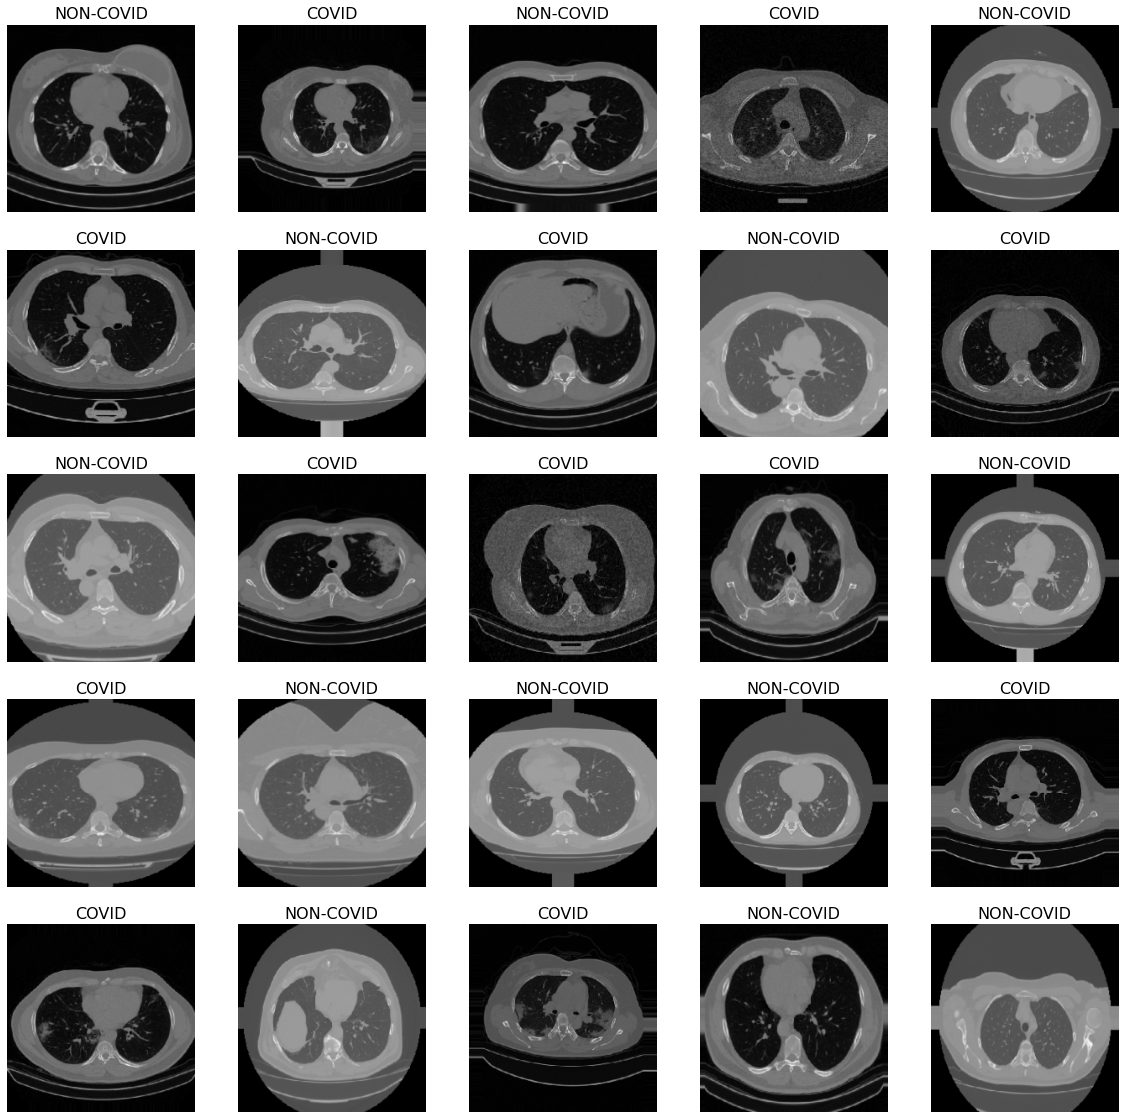

In [7]:
# Show some examples in the training set with data augmentation
show_image_samples(train_set)

In [8]:
# Create the CNN Model

# Binary classification thus set to 1 (either COVID or NON-COVID)
class_count=1

# Obtain the pre trained model - Using VGG16 & VGG19
model_name='VGG19'

# load the model from keras (Drop the fully connected layers and replace it)
base_model=tf.keras.applications.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output

# don't train existing weights inn the feature learning or feature extraction part
for layer in base_model.layers:
  layer.trainable = False

output=Dense(class_count, activation='sigmoid')(x)

# Define the model
model=Model(inputs=base_model.input, outputs=output)

# Set the learning rate as 0.001(1e-3)
learning_rate = .001

# Model compile using the Adam optimizer and binary_crossentropy loss 
model.compile(Adam(lr= learning_rate), loss='binary_crossentropy', metrics=['accuracy']) 

2021-10-07 16:37:54.034039: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 16:37:54.038528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-07 16:37:54.093427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:37:54.094290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-07 16:37:54.094376: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-07 16:37:54.123831: I tensorflow/stream_executor/platform/def

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
# Showing a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# Train on 10720 and validate on 1340 images
# Model will be saved after every epochs
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math

epochs =15
batches=train_steps

# A model checkpoint will save the best model
checkpoint = ModelCheckpoint('model_VGG19.h5', verbose=0, save_best_only=True) # Only saving the best model
# set the callbacks and save models using checkpoint
callbacks=[checkpoint]

# Train the model
history=model.fit(x=train_set, epochs=epochs, verbose=1 , callbacks = callbacks , validation_data=valid_set , shuffle=False,  initial_epoch=0)

2021-10-07 16:37:58.263703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 16:37:58.269493: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/15


2021-10-07 16:37:59.502982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-07 16:38:00.556886: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-07 16:38:00.611866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


335/335 [==============================] - 294s 846ms/step - loss: 0.6312 - accuracy: 0.6606 - val_loss: 0.4631 - val_accuracy: 0.7948
Epoch 2/15
335/335 [==============================] - 173s 518ms/step - loss: 0.4361 - accuracy: 0.8123 - val_loss: 0.4227 - val_accuracy: 0.8321
Epoch 3/15
335/335 [==============================] - 177s 530ms/step - loss: 0.3939 - accuracy: 0.8332 - val_loss: 0.4018 - val_accuracy: 0.8478
Epoch 4/15
335/335 [==============================] - 190s 567ms/step - loss: 0.3725 - accuracy: 0.8471 - val_loss: 0.3798 - val_accuracy: 0.8522
Epoch 5/15
335/335 [==============================] - 186s 555ms/step - loss: 0.3666 - accuracy: 0.8484 - val_loss: 0.3683 - val_accuracy: 0.8515
Epoch 6/15
335/335 [==============================] - 187s 559ms/step - loss: 0.3464 - accuracy: 0.8556 - val_loss: 0.3699 - val_accuracy: 0.8493
Epoch 7/15
335/335 [==============================] - 184s 549ms/step - loss: 0.3422 - accuracy: 0.8634 - val_loss: 0.3642 - val_accura